In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from ucimlrepo import fetch_ucirepo 
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, davies_bouldin_score, 
                             precision_recall_curve, average_precision_score,accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, roc_curve, auc)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.neighbors import NearestNeighbors

In [4]:
# Load dataset
adult = fetch_ucirepo(id=2) 

X = adult.data.features
y = adult.data.targets
y = y['income'].str.replace('.', '', regex=False)

# Display metadata and variables
print("Dataset Metadata:\n", adult.metadata)
print("\nDataset Variables:\n", adult.variables)

# Display an example
print("\nExample case from the dataset:")
example_case = X.iloc[0]
print("\nFeatures for first individual:")
for feature, value in example_case.items():
    print(f"{feature}: {value}")



Dataset Metadata:
 {'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extr

In [5]:
# 1. Handle missing values

# convert the “?” placeholders into real NaN
X_clean = X.copy()
for col in X_clean.select_dtypes(include=['object']):
    X_clean[col] = X_clean[col].str.strip().replace('?', np.nan)

# 2. Impute separately for numeric vs. categorical
num_cols = X_clean.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_clean.select_dtypes(include=['object']).columns.tolist()

# Numeric: median strategy 
num_imputer = SimpleImputer(strategy='median')
X_num = pd.DataFrame(
    num_imputer.fit_transform(X_clean[num_cols]),
    columns=num_cols
)

# Categorical: most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
X_cat = pd.DataFrame(
    cat_imputer.fit_transform(X_clean[cat_cols]),
    columns=cat_cols
)

X_imputed_df = pd.concat([X_num, X_cat], axis=1)[X.columns]

In [6]:
# 2. Categorical feature encoding
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 
                       'relationship', 'race', 'sex', 'native-country']
numerical_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_categorical = encoder.fit_transform(X_imputed_df[categorical_columns])
categorical_feature_names = encoder.get_feature_names_out(categorical_columns)

X_numerical = X_imputed_df[numerical_columns].values

X_transformed = np.hstack([X_numerical, X_categorical])

transformed_columns = list(numerical_columns) + list(categorical_feature_names)
X_transformed_df = pd.DataFrame(X_transformed, columns=transformed_columns)

In [7]:
# 3. Standardize numeric columns
scaler = StandardScaler()
X_transformed_df[numerical_columns] = scaler.fit_transform(
    X_transformed_df[numerical_columns]
)

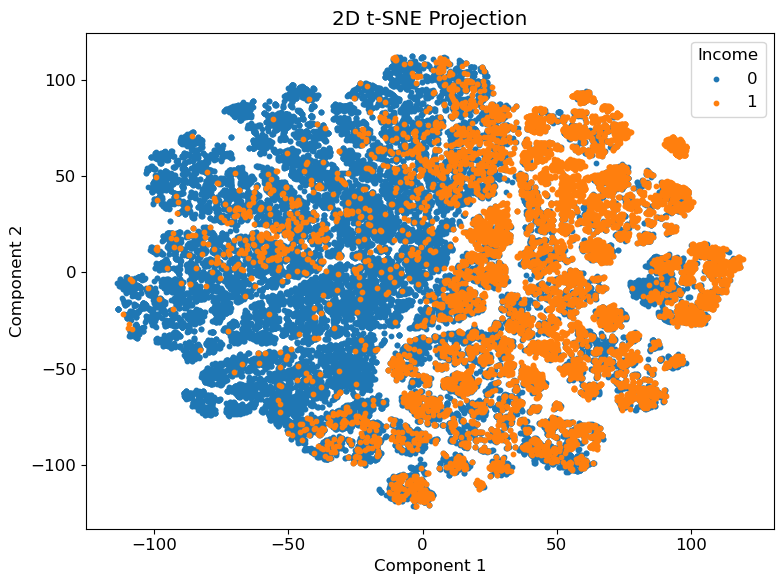

In [48]:
# 2D t-SNE embedding and scatter plot
y = y.to_numpy() if hasattr(y, 'to_numpy') else np.array(y)
tsne2 = TSNE(n_components=2, random_state=42)
X_emb2 = tsne2.fit_transform(X_transformed_df)
plt.figure(figsize=(8,6))
for cls in np.unique(y):
    mask = (y == cls).flatten()
    plt.scatter(X_emb2[mask,0], X_emb2[mask,1], label=cls, s=10)
plt.legend(title='Income')
plt.title('2D t-SNE Projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()
plt.show()


In [51]:
# # 3D t-SNE embedding and scatter plot
# tsne3 = TSNE(n_components=3, random_state=42)
# X_emb3 = tsne3.fit_transform(X_transformed_df)
# fig = plt.figure(figsize=(8,6))
# ax = fig.add_subplot(111, projection='3d')
# for cls in np.unique(y):
#     mask = (y == cls).flatten()
#     ax.scatter(X_emb3[mask,0], X_emb3[mask,1], X_emb3[mask,2], label=cls, s=0.5, alpha=0.7)
# ax.legend(title='Income')
# ax.set_title('3D t-SNE Projection')
# ax.set_xlabel('Component 1')
# ax.set_ylabel('Component 2')
# ax.set_zlabel('Component 3')
# ax.view_init(elev=25, azim=45)
# plt.tight_layout()
# plt.show()

tsne3 = TSNE(n_components=3, random_state=42)
X_emb3 = tsne3.fit_transform(X_transformed_df)

trace_list = []
for cls in np.unique(y):
    mask = (y == cls).flatten()
    trace = go.Scatter3d(
        x=X_emb3[mask, 0],
        y=X_emb3[mask, 1],
        z=X_emb3[mask, 2],
        mode='markers',
        marker=dict(size=0.8, opacity=0.7),
        name=str(cls),
        text=[f'GroundTruth: {label}' for label in y[mask]],  # 添加groundtruth信息
        hoverinfo='text'
    )
    trace_list.append(trace)

layout = go.Layout(
    title='3D t-SNE Projection',
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    )
)

fig = go.Figure(data=trace_list, layout=layout)
fig.show()

In [11]:
#clustering and evaluate the results

k = 2
random_state = 42

kmeans = KMeans(
    n_clusters=k,
    init='k-means++',
    n_init=50,               
    max_iter=500,
    tol=1e-4,
    algorithm='elkan',    
    random_state=random_state
)
kmeans_labels = kmeans.fit_predict(X_emb3)

agg_clustering = AgglomerativeClustering(
    n_clusters=k,   
    linkage='ward',       
    compute_full_tree='auto'
)
agg_labels = agg_clustering.fit_predict(X_emb3)

def evaluate_clustering(X, labels, y_true=None):
    metrics = {
        'Silhouette Score': silhouette_score(X, labels),
        'Calinski-Harabasz Score': calinski_harabasz_score(X, labels),
        'Davies-Bouldin Score': davies_bouldin_score(X, labels)
    }
    
    if y_true is not None:
        from sklearn.metrics import adjusted_rand_score
        metrics['Adjusted Rand Score'] = adjusted_rand_score(y_true, labels)
    
    return metrics

kmeans_metrics = evaluate_clustering(X_emb3, kmeans_labels, y)
agg_metrics = evaluate_clustering(X_emb3, agg_labels, y)

metrics_df = pd.DataFrame({
    'K-Means': kmeans_metrics,
    'Agglomerative': agg_metrics
}).T

print("\nClustering Performance Comparison:")
print(metrics_df)


# fig = plt.figure(figsize=(18, 6))


# ax1 = fig.add_subplot(132, projection='3d')
# for cluster in range(k):
#     mask = (kmeans_labels == cluster)
#     ax1.scatter(X_emb3[mask,0], X_emb3[mask,1], X_emb3[mask,2], 
#                label=f'Cluster {cluster}', s=5, alpha=0.6)
# ax1.set_title('K-Means Clustering Results')

# ax2 = fig.add_subplot(133, projection='3d')
# for cluster in range(k):
#     mask = (agg_labels == cluster)
#     ax2.scatter(X_emb3[mask,0], X_emb3[mask,1], X_emb3[mask,2], 
#                label=f'Cluster {cluster}', s=5, alpha=0.6)
# ax2.set_title('Agglomerative Clustering Results')

# plt.tight_layout()
# plt.show()
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'scene'}, {'type': 'scene'}]],
    subplot_titles=("K-Means Clustering Results", "Agglomerative Clustering Results")
)

# K-Means 聚类结果
for cluster in range(k):
    mask = (kmeans_labels == cluster)
    fig.add_trace(
        go.Scatter3d(
            x=X_emb3[mask,0],
            y=X_emb3[mask,1],
            z=X_emb3[mask,2],
            mode='markers',
            marker=dict(size=0.8, opacity=0.7),
            name=f'KMeans-{cluster}',
            legendgroup=f'KMeans-{cluster}'
        ),
        row=1, col=1
    )

# Agglomerative 聚类结果
for cluster in range(k):
    mask = (agg_labels == cluster)
    fig.add_trace(
        go.Scatter3d(
            x=X_emb3[mask,0],
            y=X_emb3[mask,1],
            z=X_emb3[mask,2],
            mode='markers',
            marker=dict(size=0.8, opacity=0.7),
            name=f'Agg-{cluster}',
            legendgroup=f'Agg-{cluster}'
        ),
        row=1, col=2
    )

fig.update_layout(
    height=600, width=1200,
    title_text="3D Clustering Results (K-Means vs Agglomerative)",
    showlegend=True
)
fig.update_scenes(
    xaxis_title_text='Component 1',
    yaxis_title_text='Component 2',
    zaxis_title_text='Component 3'
)
fig.show()


Clustering Performance Comparison:
               Silhouette Score  Calinski-Harabasz Score  \
K-Means                0.246131             16804.794922   
Agglomerative          0.214741             13179.875977   

               Davies-Bouldin Score  Adjusted Rand Score  
K-Means                    1.622996             0.080296  
Agglomerative              1.678743             0.140342  


In [ ]:
y = (adult.data.targets['income'].str.replace('.', '', regex=False) == '>50K').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed_df, y, test_size=0.3, random_state=42, stratify=y
)

pos_count = np.sum(y == 1)
neg_count = np.sum(y == 0)
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1

models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=150,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,  
        eval_metric='auc',
        base_score=0.5,
        random_state=42,
        n_jobs=-1
    ),
    "Logistic Regression": LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=15,  # 与Random Forest一致
        class_weight='balanced',
        random_state=42
    )
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

def evaluate_model(model, X, y, dataset_name=""):
    y_pred = model.predict(X)
    
    y_proba = model.predict_proba(X)
    if y_proba.shape[1] == 1:
        y_proba = y_proba[:, 0]
    else:
        y_proba = y_proba[:, 1]
    
    metrics = {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0),
        'F1': f1_score(y, y_pred, zero_division=0),
    }
    
    if len(np.unique(y)) > 1:
        metrics['ROC AUC'] = roc_auc_score(y, y_proba)
    else:
        metrics['ROC AUC'] = None  
    
    cm = confusion_matrix(y, y_pred)
    
    report = classification_report(y, y_pred, output_dict=True)
    
    return metrics, cm, report

results = {}
datasets = {
    'Training': (X_train, y_train),
    'Testing': (X_test, y_test),
    'Full': (X_transformed_df, y)
}

for name, model in models.items():
    model_results = {}
    for dataset_name, (X, y_true) in datasets.items():
        metrics, cm, report = evaluate_model(model, X, y_true, dataset_name)
        model_results[dataset_name] = {
            'metrics': metrics,
            'cm': cm,
            'report': report
        }
    results[name] = model_results




Training Random Forest...

Training XGBoost...

Training Logistic Regression...

Training Decision Tree...


In [60]:
depths = [50, 100, 300]

# 存储结果
results_dt = {'depth': [], 'train_acc': [], 'test_acc': []}
results_rf = {'depth': [], 'train_acc': [], 'test_acc': []}

for depth in depths:
    # 决策树
    dt = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=42)
    dt.fit(X_train, y_train)
    train_acc_dt = dt.score(X_train, y_train)
    test_acc_dt = dt.score(X_test, y_test)
    results_dt['depth'].append(depth)
    results_dt['train_acc'].append(train_acc_dt)
    results_dt['test_acc'].append(test_acc_dt)

    # 随机森林
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=depth,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    train_acc_rf = rf.score(X_train, y_train)
    test_acc_rf = rf.score(X_test, y_test)
    results_rf['depth'].append(depth)
    results_rf['train_acc'].append(train_acc_rf)
    results_rf['test_acc'].append(test_acc_rf)

import pandas as pd
print("Decision Tree 不同深度准确率：")
display(pd.DataFrame(results_dt))
print("Random Forest 不同深度准确率：")
display(pd.DataFrame(results_rf))

Decision Tree 不同深度准确率：


depth  train_acc  test_acc
0     50   0.998947  0.822835
1    100   0.999883  0.822630
2    300   0.999883  0.822630

Random Forest 不同深度准确率：


depth  train_acc  test_acc
0     50   0.837404  0.821675
1    100   0.837287  0.821470
2    300   0.837287  0.821470

/opt/anaconda3/envs/dsaa/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/opt/anaconda3/envs/dsaa/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names

/opt/anaconda3/envs/dsaa/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



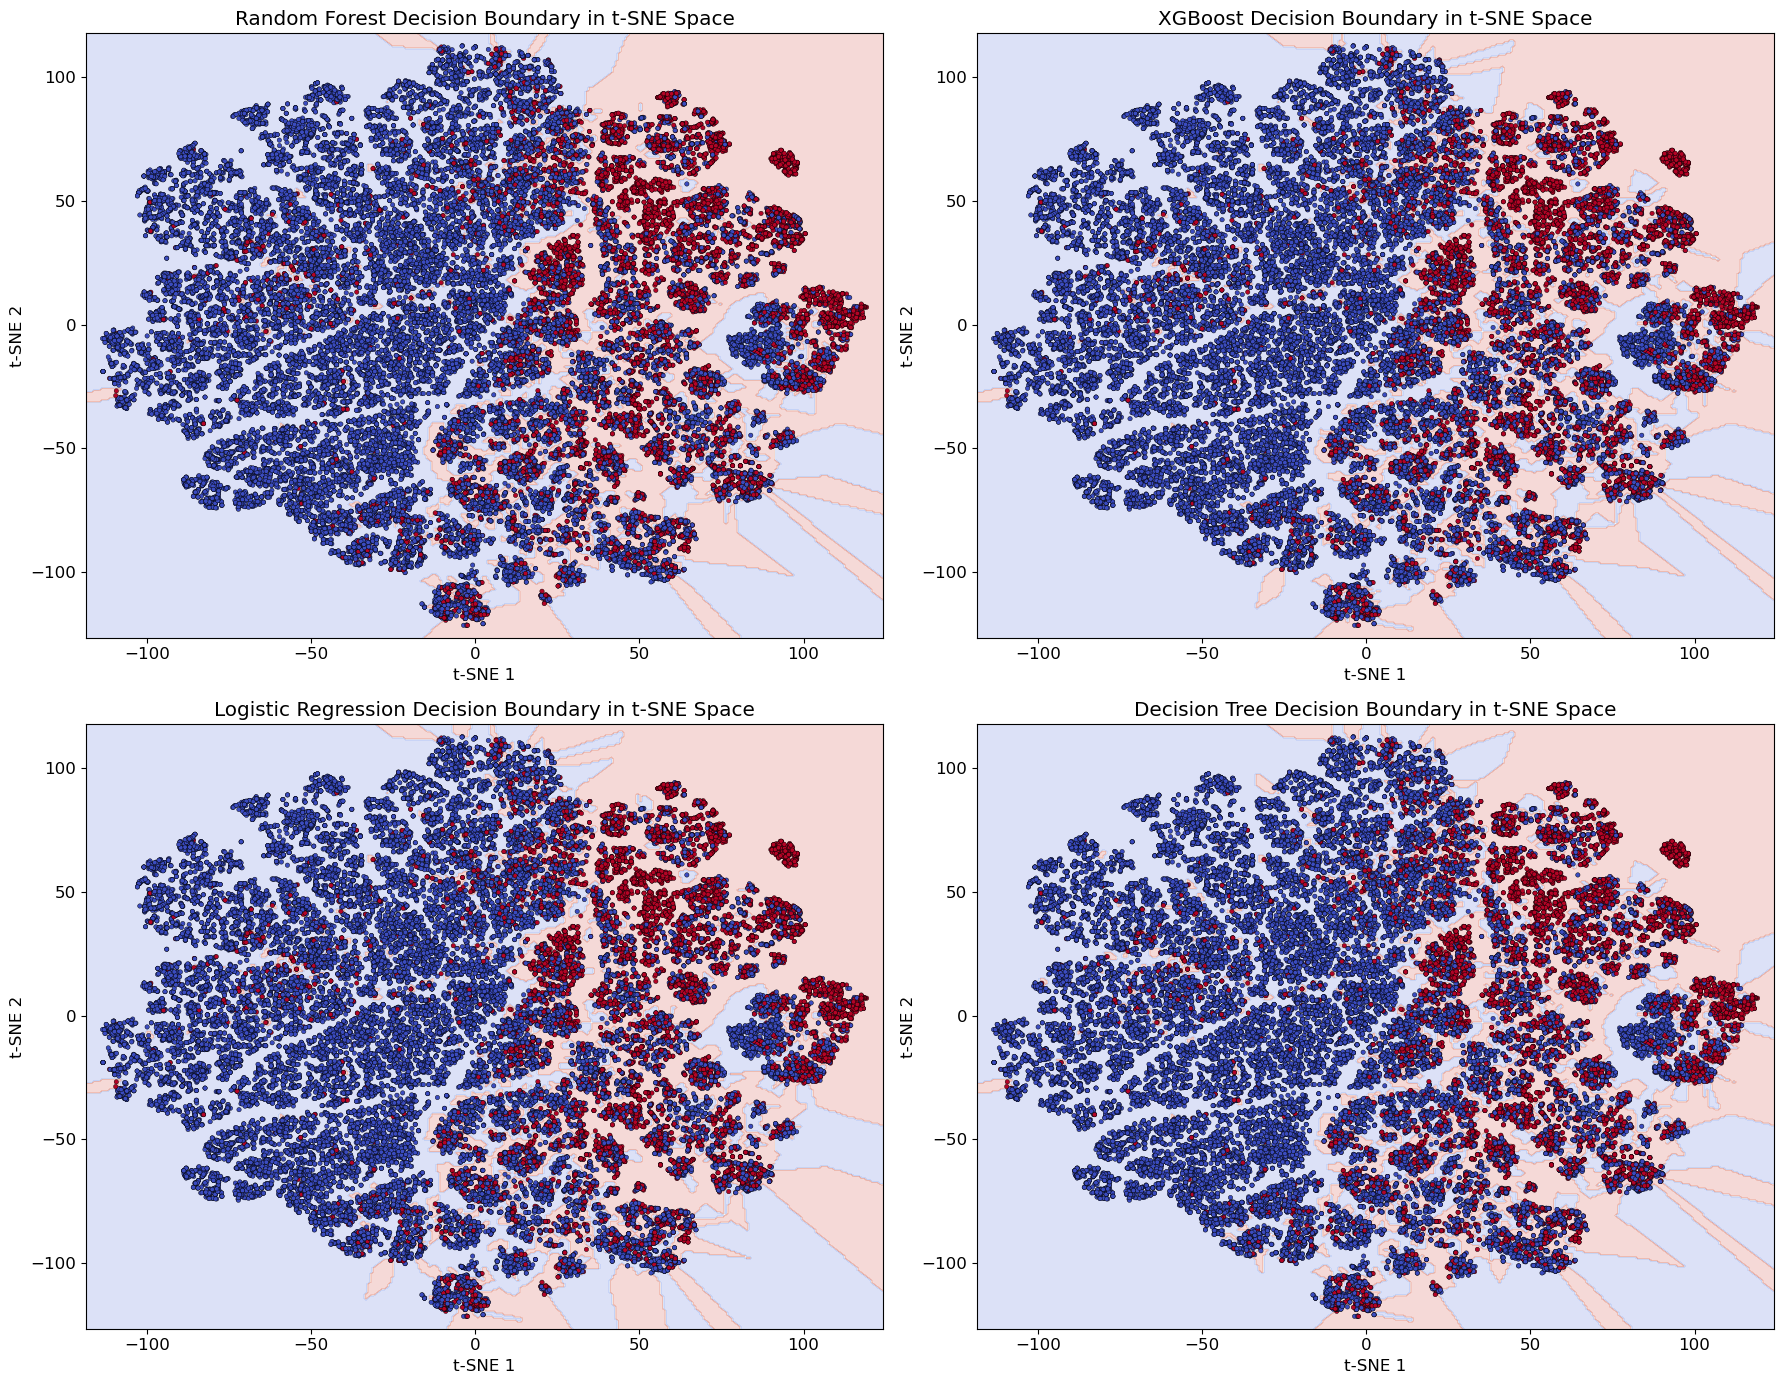

In [57]:
# 使用上面降维到2D的变量
X_emb2 = TSNE(n_components=2, random_state=42).fit_transform(X_transformed_df)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))  # 创建2x2子图
axes = axes.flatten()  # 方便用索引访问

for idx, (model_name, clf) in enumerate(models.items()):
    # 在t-SNE空间生成网格
    x_min, x_max = X_emb2[:, 0].min() - 5, X_emb2[:, 0].max() + 5
    y_min, y_max = X_emb2[:, 1].min() - 5, X_emb2[:, 1].max() + 5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # 找到每个网格点最近的原始点
    nn = NearestNeighbors(n_neighbors=1).fit(X_emb2)
    _, idxs = nn.kneighbors(grid_points)
    X_high_near = X_transformed_df.iloc[idxs.flatten()].values

    # 用模型预测类别
    y_pred_grid = clf.predict(X_high_near)

    # 可视化决策边界
    ax = axes[idx]
    ax.contourf(xx, yy, y_pred_grid.reshape(xx.shape), alpha=0.2, cmap='coolwarm')
    ax.scatter(X_emb2[:, 0], X_emb2[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=10,linewidths=0.3)
    ax.set_title(f'{model_name} Decision Boundary in t-SNE Space')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

/opt/anaconda3/envs/dsaa/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/opt/anaconda3/envs/dsaa/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names

/opt/anaconda3/envs/dsaa/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



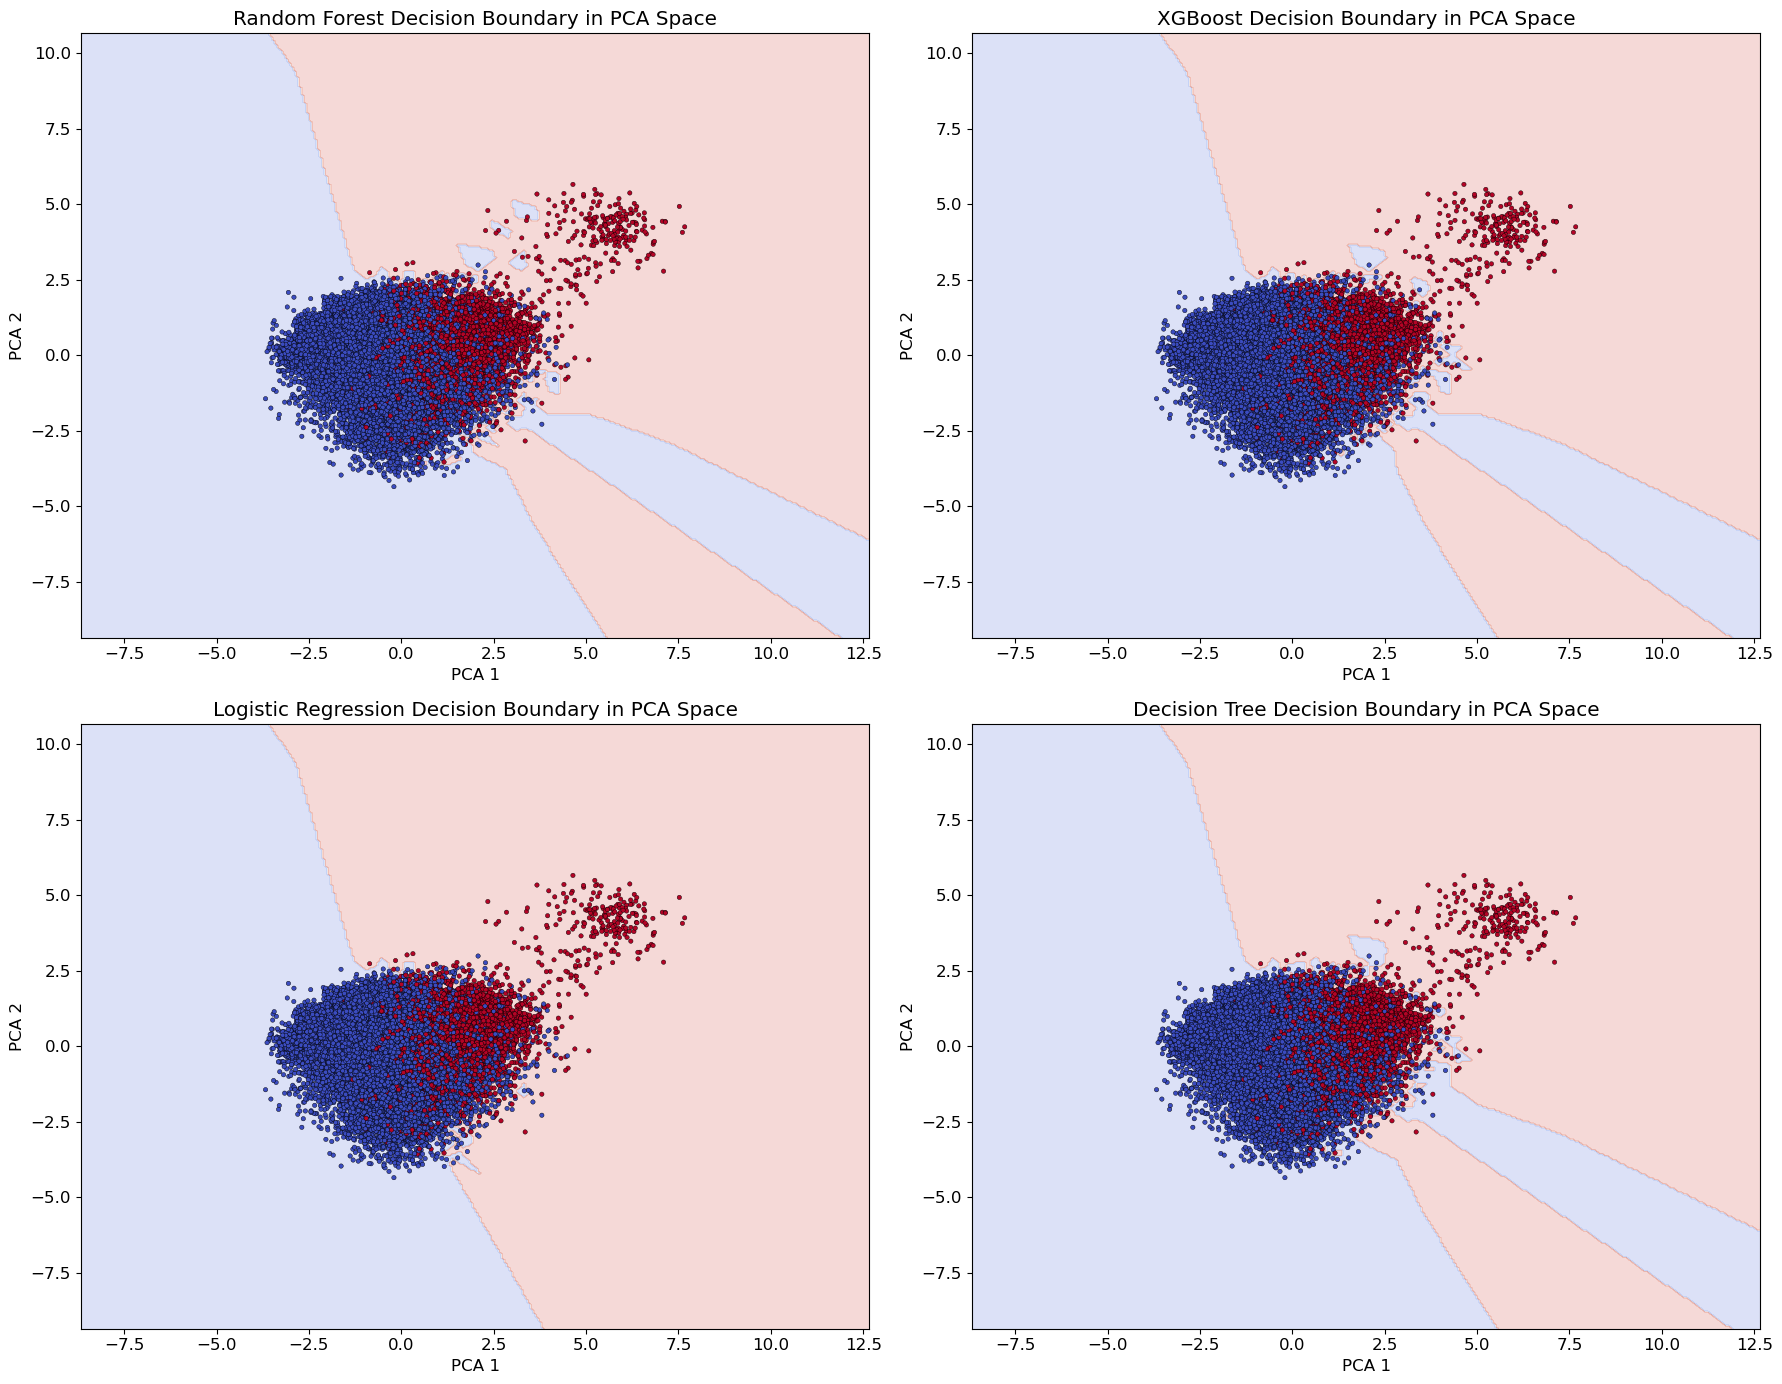

In [56]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 使用PCA降维到2D
X_emb2_pca = PCA(n_components=2, random_state=42).fit_transform(X_transformed_df)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))  # 创建2x2子图
axes = axes.flatten()  # 方便用索引访问

for idx, (model_name, clf) in enumerate(models.items()):
    # 在PCA空间生成网格
    x_min, x_max = X_emb2_pca[:, 0].min() - 5, X_emb2_pca[:, 0].max() + 5
    y_min, y_max = X_emb2_pca[:, 1].min() - 5, X_emb2_pca[:, 1].max() + 5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # 找到每个网格点最近的原始点
    nn = NearestNeighbors(n_neighbors=1).fit(X_emb2_pca)
    _, idxs = nn.kneighbors(grid_points)
    X_high_near = X_transformed_df.iloc[idxs.flatten()].values

    # 用模型预测类别
    y_pred_grid = clf.predict(X_high_near)

    # 可视化决策边界
    ax = axes[idx]
    ax.contourf(xx, yy, y_pred_grid.reshape(xx.shape), alpha=0.2, cmap='coolwarm')
    ax.scatter(X_emb2_pca[:, 0], X_emb2_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=10,linewidths=0.3)
    ax.set_title(f'{model_name} Decision Boundary in PCA Space')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')

plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

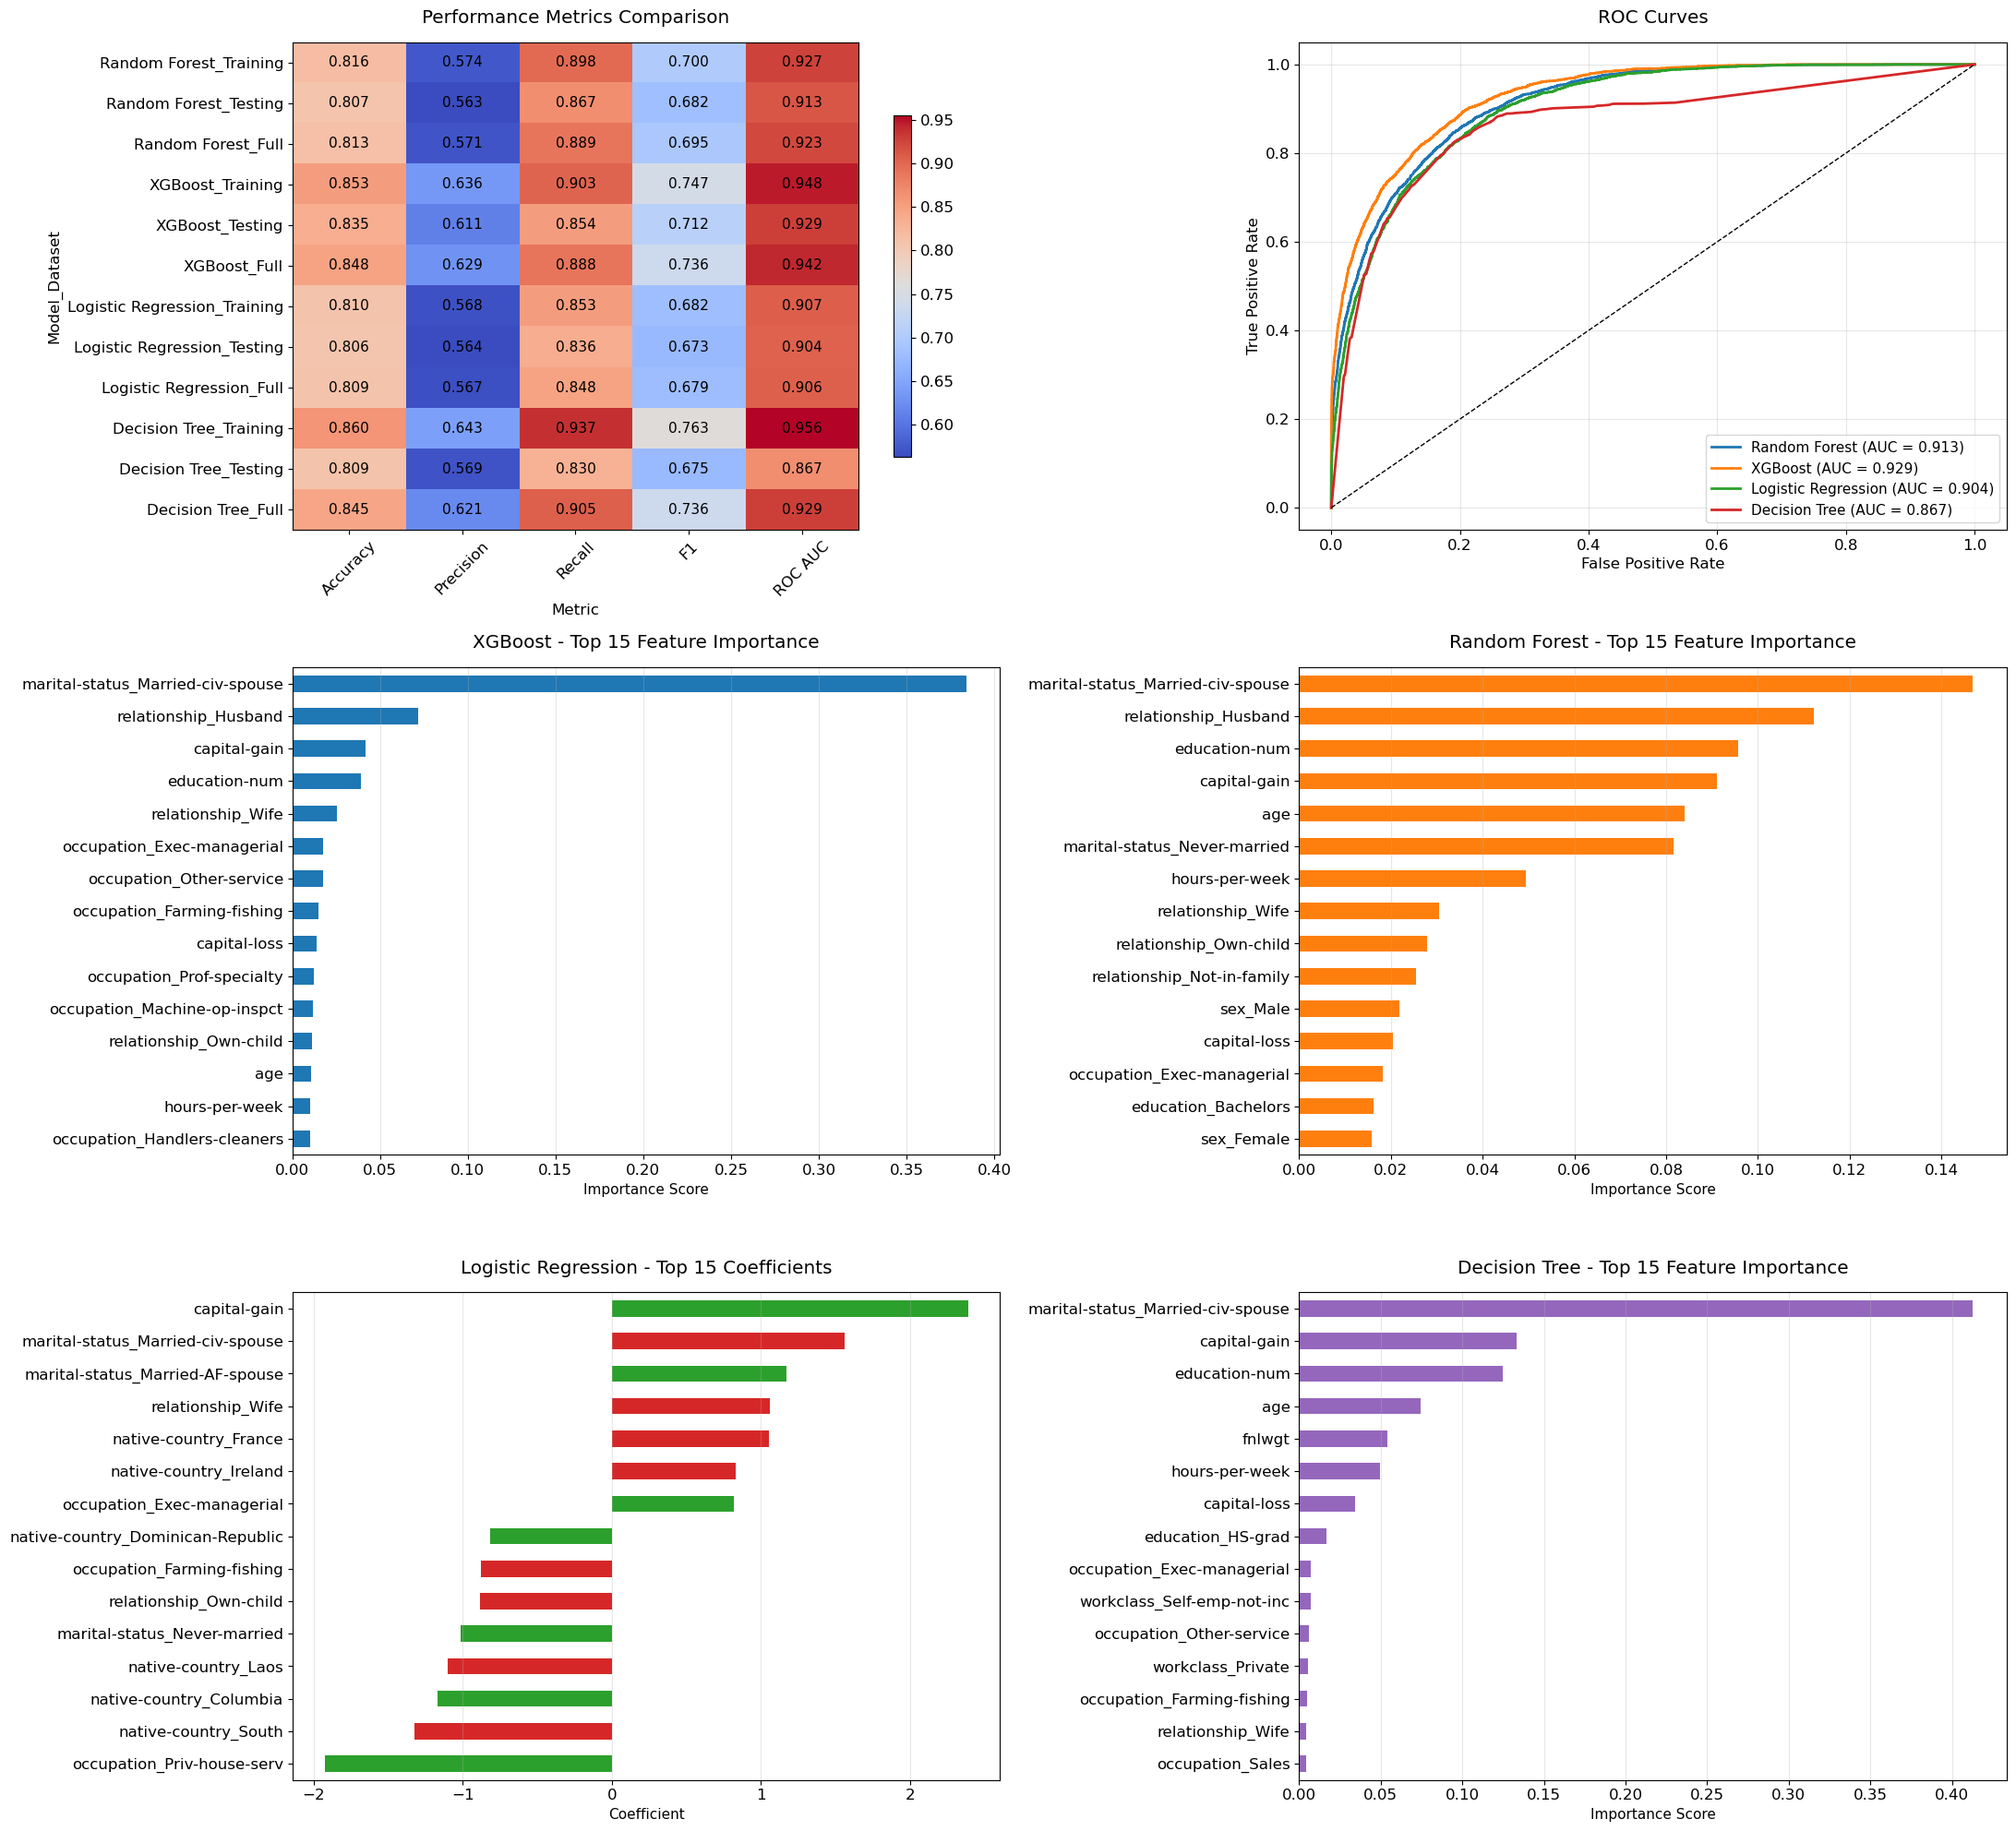

In [45]:
#Visualization
plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 12})

fig, axs = plt.subplots(3, 2, figsize=(22,20))
plt.subplots_adjust(wspace=0.3, hspace=0.4)  

ax1 = axs[0, 0]
metrics_df = pd.DataFrame()
for model_name, model_results in results.items():
    for dataset_name, res in model_results.items():
        temp_df = pd.DataFrame(res['metrics'], index=[f"{model_name}_{dataset_name}"])
        metrics_df = pd.concat([metrics_df, temp_df])

metrics_df = metrics_df.astype(float)
cax = ax1.imshow(metrics_df, cmap='coolwarm', aspect='auto')
fig.colorbar(cax, ax=ax1, shrink=0.7)
ax1.set_title("Performance Metrics Comparison", pad=15)
ax1.set_xlabel("Metric")
ax1.set_ylabel("Model_Dataset")

ax1.set_xticks(np.arange(len(metrics_df.columns)))
ax1.set_xticklabels(metrics_df.columns, rotation=45)
ax1.set_yticks(np.arange(len(metrics_df.index)))
ax1.set_yticklabels(metrics_df.index)
for i in range(metrics_df.shape[0]):
    for j in range(metrics_df.shape[1]):
        ax1.text(j, i, f"{metrics_df.iloc[i, j]:.3f}", ha='center', va='center', color='black', fontsize=11)

ax2 = axs[0, 1]
for name, model in models.items():
    y_proba = model.predict_proba(X_test)
    if y_proba.shape[1] == 1:
        y_proba = y_proba[:, 0]
    else:
        y_proba = y_proba[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=1)
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('ROC Curves', pad=15)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

ax3 = axs[1, 0]
feat_importances = pd.Series(models['XGBoost'].feature_importances_, 
                            index=X_transformed_df.columns)
top15_xgb = feat_importances.nlargest(15)
top15_xgb.sort_values().plot(kind='barh', ax=ax3, color='#1f77b4')
ax3.set_title('XGBoost - Top 15 Feature Importance', pad=15)
ax3.set_xlabel('Importance Score', fontsize=11)
ax3.grid(True, axis='x', alpha=0.3)

ax4 = axs[1, 1]
feat_importances = pd.Series(models['Random Forest'].feature_importances_, 
                           index=X_transformed_df.columns)
top15_rf = feat_importances.nlargest(15)
top15_rf.sort_values().plot(kind='barh', ax=ax4, color='#ff7f0e')
ax4.set_title('Random Forest - Top 15 Feature Importance', pad=15)
ax4.set_xlabel('Importance Score', fontsize=11)
ax4.grid(True, axis='x', alpha=0.3)

ax5 = axs[2, 0]
coefs = pd.Series(models['Logistic Regression'].coef_.flatten(), index=X_transformed_df.columns)
top15_lr = coefs.abs().nlargest(15)
top15_lr = coefs[top15_lr.index]  # 保留正负号
colors = top15_lr.apply(lambda x: '#2ca02c' if x > 0 else '#d62728')
top15_lr.sort_values().plot(kind='barh', ax=ax5, color=colors)
ax5.set_title('Logistic Regression - Top 15 Coefficients', pad=15)
ax5.set_xlabel('Coefficient', fontsize=11)
ax5.grid(True, axis='x', alpha=0.3)

ax6 = axs[2, 1]
feat_importances = pd.Series(models['Decision Tree'].feature_importances_, index=X_transformed_df.columns)
top15_dt = feat_importances.nlargest(15)
top15_dt.sort_values().plot(kind='barh', ax=ax6, color='#9467bd')
ax6.set_title('Decision Tree - Top 15 Feature Importance', pad=15)
ax6.set_xlabel('Importance Score', fontsize=11)
ax6.grid(True, axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:

# 有监督聚类（以Logistic Regression为例）
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_emb3, y)
y_pred = clf.predict(X_emb3)

# 计算TP/TN/FP/FN
TP = (y_pred == 1) & (y == 1)
TN = (y_pred == 0) & (y == 0)
FP = (y_pred == 1) & (y == 0)
FN = (y_pred == 0) & (y == 1)

# 可视化TP/TN/FP/FN
fig2 = go.Figure()
fig2.add_trace(go.Scatter3d(x=X_emb3[TP,0], y=X_emb3[TP,1], z=X_emb3[TP,2],
                            mode='markers', marker=dict(size=0.8, color='green', opacity=0.7), name='TP'))
fig2.add_trace(go.Scatter3d(x=X_emb3[TN,0], y=X_emb3[TN,1], z=X_emb3[TN,2],
                            mode='markers', marker=dict(size=0.8, color='blue', opacity=0.7), name='TN'))
fig2.add_trace(go.Scatter3d(x=X_emb3[FP,0], y=X_emb3[FP,1], z=X_emb3[FP,2],
                            mode='markers', marker=dict(size=0.8, color='red', opacity=0.7), name='FP'))
fig2.add_trace(go.Scatter3d(x=X_emb3[FN,0], y=X_emb3[FN,1], z=X_emb3[FN,2],
                            mode='markers', marker=dict(size=0.8, color='orange', opacity=0.7), name='FN'))
fig2.update_layout(
    title="Supervised (Logistic Regression) TP/TN/FP/FN Visualization",
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    ),
    legend=dict(itemsizing='constant')
)
fig2.show()


Supervised (Logistic Regression) Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     37155
           1       0.58      0.37      0.46     11687

    accuracy                           0.79     48842
   macro avg       0.70      0.64      0.66     48842
weighted avg       0.77      0.79      0.77     48842

Confusion Matrix:
[[34066  3089]
 [ 7334  4353]]


In [39]:
metrics_summary = []

for model_name in results.keys():
    test_metrics = results[model_name]['Testing']['metrics']
    test_cm = results[model_name]['Testing']['cm']
    
    fpr, tpr, _ = roc_curve(y_test, models[model_name].predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(
        y_test, models[model_name].predict_proba(X_test)[:, 1])
    ap_score = average_precision_score(
        y_test, models[model_name].predict_proba(X_test)[:, 1])
    
    metrics_summary.append({
        'Model': model_name,
        'Accuracy': test_metrics['Accuracy'],
        'Precision': test_metrics['Precision'],
        'Recall': test_metrics['Recall'],
        'F1': test_metrics['F1'],
        'ROC AUC': roc_auc,
        'AP Score': ap_score,
        'Confusion Matrix': test_cm
    })

metrics_df = pd.DataFrame(metrics_summary).set_index('Model')

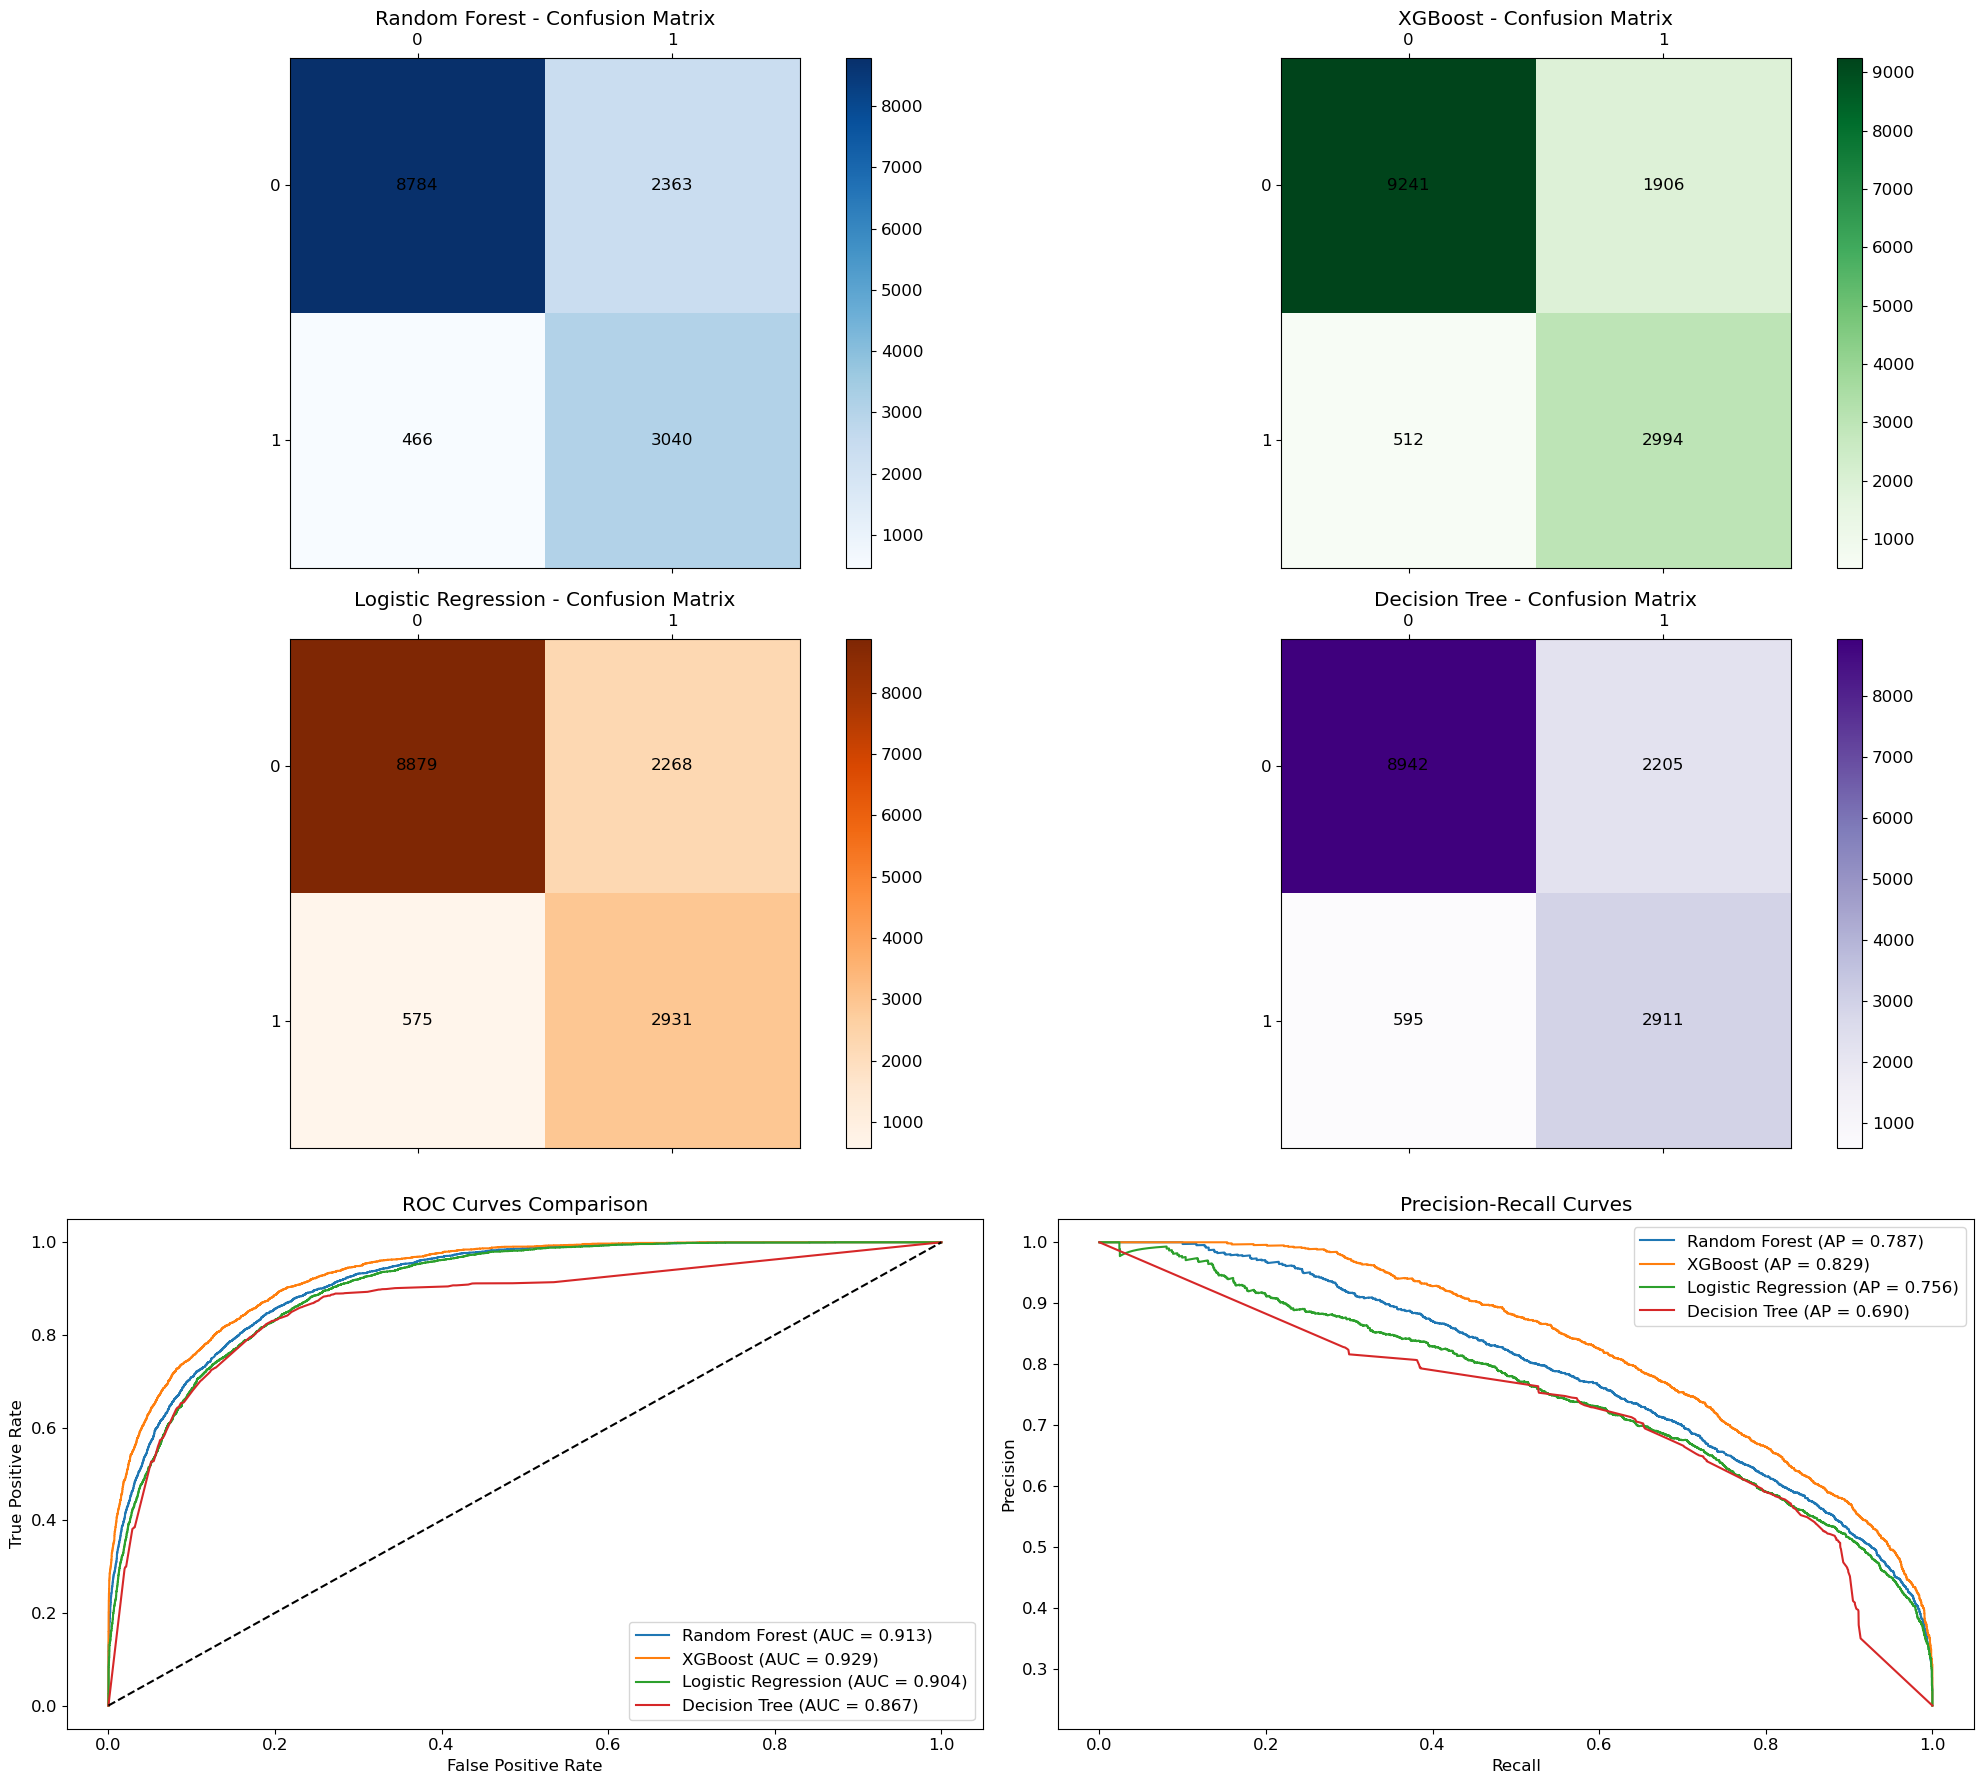

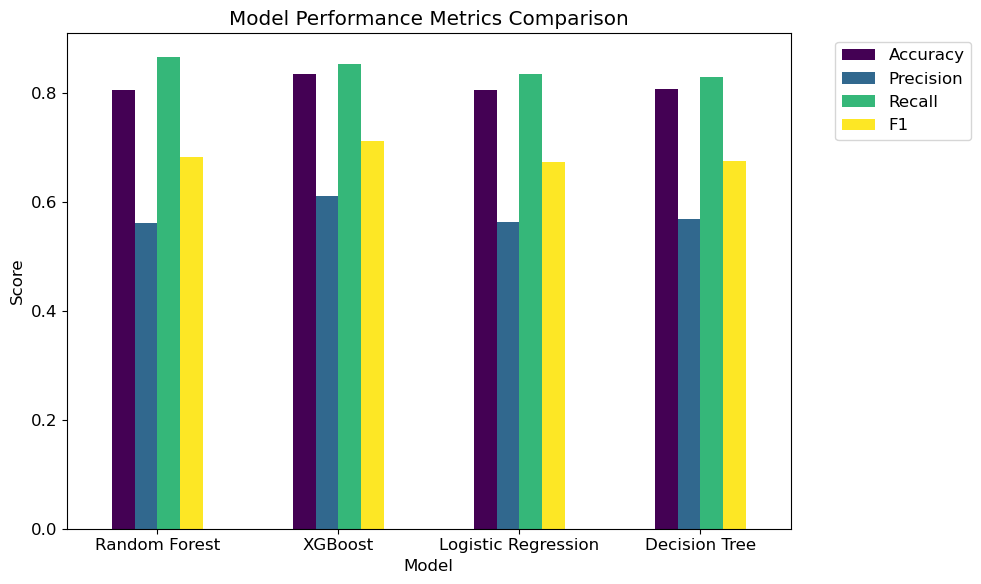

In [40]:
# 6个子图：4个混淆矩阵 + ROC + PR
fig, axs = plt.subplots(3, 2, figsize=(20, 18))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Random Forest
cax1 = axs[0, 0].matshow(metrics_df.loc['Random Forest', 'Confusion Matrix'], cmap='Blues')
fig.colorbar(cax1, ax=axs[0, 0])
axs[0, 0].set_title('Random Forest - Confusion Matrix')
for (i, j), val in np.ndenumerate(metrics_df.loc['Random Forest']['Confusion Matrix']):
    axs[0, 0].text(j, i, f'{val}', ha='center', va='center', color='black')

# XGBoost
cax2 = axs[0, 1].matshow(metrics_df.loc['XGBoost', 'Confusion Matrix'], cmap='Greens')
fig.colorbar(cax2, ax=axs[0, 1])
axs[0, 1].set_title('XGBoost - Confusion Matrix')
for (i, j), val in np.ndenumerate(metrics_df.loc['XGBoost']['Confusion Matrix']):
    axs[0, 1].text(j, i, f'{val}', ha='center', va='center', color='black')

# Logistic Regression
cax3 = axs[1, 0].matshow(metrics_df.loc['Logistic Regression', 'Confusion Matrix'], cmap='Oranges')
fig.colorbar(cax3, ax=axs[1, 0])
axs[1, 0].set_title('Logistic Regression - Confusion Matrix')
for (i, j), val in np.ndenumerate(metrics_df.loc['Logistic Regression']['Confusion Matrix']):
    axs[1, 0].text(j, i, f'{val}', ha='center', va='center', color='black')

# Decision Tree
cax4 = axs[1, 1].matshow(metrics_df.loc['Decision Tree', 'Confusion Matrix'], cmap='Purples')
fig.colorbar(cax4, ax=axs[1, 1])
axs[1, 1].set_title('Decision Tree - Confusion Matrix')
for (i, j), val in np.ndenumerate(metrics_df.loc['Decision Tree']['Confusion Matrix']):
    axs[1, 1].text(j, i, f'{val}', ha='center', va='center', color='black')

# ROC曲线
for model_name in results.keys():
    fpr, tpr, _ = roc_curve(y_test, models[model_name].predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    axs[2, 0].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')
axs[2, 0].plot([0, 1], [0, 1], 'k--')
axs[2, 0].set_xlabel('False Positive Rate')
axs[2, 0].set_ylabel('True Positive Rate')
axs[2, 0].set_title('ROC Curves Comparison')
axs[2, 0].legend()

# PR曲线
for model_name in results.keys():
    precision, recall, _ = precision_recall_curve(
        y_test, models[model_name].predict_proba(X_test)[:, 1])
    ap_score = average_precision_score(
        y_test, models[model_name].predict_proba(X_test)[:, 1])
    axs[2, 1].plot(recall, precision, label=f'{model_name} (AP = {ap_score:.3f})')
axs[2, 1].set_xlabel('Recall')
axs[2, 1].set_ylabel('Precision')
axs[2, 1].set_title('Precision-Recall Curves')
axs[2, 1].legend()

plt.tight_layout()
plt.show()

# 单独画性能条形图
plt.figure(figsize=(10, 6))
metrics_df[['Accuracy', 'Precision', 'Recall', 'F1']].plot(
    kind='bar', rot=0, colormap='viridis', ax=plt.gca())
plt.title('Model Performance Metrics Comparison')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [41]:
cv_results = {}
for name, model in models.items():
    cv_scores = cross_val_score(
        model, X_transformed_df, y, 
        cv=5, scoring='roc_auc', n_jobs=-1
    )
    cv_results[name] = {
        'Mean AUC': np.mean(cv_scores),
        'Std AUC': np.std(cv_scores),
        'Scores': cv_scores
    }
print("Cross-Validation Results:")
for name, res in cv_results.items():
    print(f"\n{name}:")
    print(f"  Mean AUC: {res['Mean AUC']:.4f}")
    print(f"  Std AUC: ±{res['Std AUC']:.4f}")

Cross-Validation Results:

Random Forest:
  Mean AUC: 0.9131
  Std AUC: ±0.0023

XGBoost:
  Mean AUC: 0.9290
  Std AUC: ±0.0019

Logistic Regression:
  Mean AUC: 0.9051
  Std AUC: ±0.0032

Decision Tree:
  Mean AUC: 0.8660
  Std AUC: ±0.0059


In [42]:
overfitting_report = []
for name in results.keys():
    train_auc = roc_auc_score(
        y_train, models[name].predict_proba(X_train)[:, 1])
    test_auc = metrics_df.loc[name, 'ROC AUC']
    diff = train_auc - test_auc
    
    overfitting_report.append({
        'Model': name,
        'Train AUC': train_auc,
        'Test AUC': test_auc,
        'Difference': diff
    })

overfitting_df = pd.DataFrame(overfitting_report).set_index('Model')
print("\nOverfitting Analysis:")
print(overfitting_df)


Overfitting Analysis:
                     Train AUC  Test AUC  Difference
Model                                               
Random Forest         0.926929  0.913395    0.013534
XGBoost               0.947837  0.929203    0.018635
Logistic Regression   0.907480  0.903822    0.003657
Decision Tree         0.955558  0.866894    0.088664
